In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from pathlib import Path
import numpy as np
sys.path.insert(0, "..")

# Get the data
We already saw how we could push the accuracy up, just by adding a combination of `Conv2D` and `MaxPool2D` layers on top of our `Dense` layers. 

Now, let's try images that are much more challenging.

The data is downloaded from an url, and stored locally

In [2]:
data_dir = Path("..") / "data/raw"
data_dir

PosixPath('../data/raw')

In [4]:
from src.data import make_dataset
make_dataset.get_raw_data(data_dir)

2021-08-17 19:20:58.221 | INFO     | src.data.make_dataset:get_raw_data:19 - found flowers in ../data/raw/flower_photos, not downloading again


We have obtained 5 folders of photos, 230MB in size. They are stored in `data/raw/flower_photos/`. We can look at the contents of the dir, and print the location itself.

In [5]:
# size in MB
!du -mh $data_dir
data_dir

 39M	../data/raw/flower_photos/roses
 54M	../data/raw/flower_photos/sunflowers
 34M	../data/raw/flower_photos/daisy
 48M	../data/raw/flower_photos/dandelion
 54M	../data/raw/flower_photos/tulips
229M	../data/raw/flower_photos
229M	../data/raw


PosixPath('../data/raw')

Containing more than 3000 files in total

In [6]:
!find $data_dir -type f | wc -l

    3672


## helper functions
To load the data, we will have to create a generator. The basic flow of creating an Image generator is like this:
-  we specify an ImageDataGenerator with some arguments like rescaling and train-test split
- we point the ImageDataGenerator to a directory on disk with `.flow_from_directory`, passing along keywords to specify train or valid set, target size and batch size. Interpolation defines the method to resize the image.

In [7]:
config = {"target_size" : (180, 180), 
          "batch_size" : 32,
          "data_dir" : data_dir.absolute() / "flower_photos"}

In [14]:
from src.data import make_dataset

datagen_kwargs = dict(rescale=1./255, validation_split=0.2)
dataflow_kwargs = dict(target_size=config["target_size"], batch_size=config["batch_size"],
                    interpolation="bilinear")

train, valid = make_dataset.create_generators(datagen_kwargs, dataflow_kwargs, config)

2021-08-17 19:24:50.371 | INFO     | src.data.make_dataset:create_generators:39 - Creating validation set data generator
2021-08-17 19:24:50.413 | INFO     | src.data.make_dataset:create_generators:49 - Creating train set data generator


Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


The generator is lazy. It will only start working if we call it with next. It will then spit out one batch of 32 images, sized 180x180x3, and one batch of labels.
If we want to use data augementation, the ImageGenerator accepts parameters for that. Because we want to reuse this flow, we will wrap this up in a function in order to avoid copy-pasting stuff all the time.

In [12]:
X, y = next(train)

In [13]:
X.shape, y.shape

((32, 180, 180, 3), (32, 5))

In [20]:
class_names = train.class_indices
print(class_names)

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [22]:
train.num_classes

5

# Explore dataset
Let's visualize some images

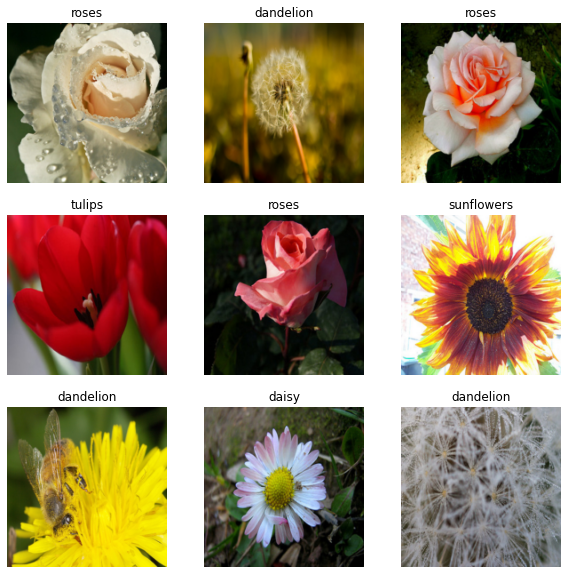

In [23]:
from src.visualization import visualize

visualize.plot_batch(train)

This is really something else than the MNIST with handwritten numbers! Images are really very diverse. 

And big, too! We scaled them all down to 180x180, but still, this is much much much more then 28x28. With 180x180 we have over 30.000 pixels for every image! That is 30.000 features. This is way above what we can expect to handle with something like a SVM, especially because we have just 3000 images, about 500 per class! 

And, in addition to the scale: our idea of treating every pixel as a feature is very sensitive to location. That only works if we find certain pixels always at the same location (like with a digit that is always centered in the image, and written in the same direction). While we could get away with that assumption for the MNIST, this assumption will fail for this dataset. We will find a table, with some flowers on it, or a green field with a girl on it and some daisis at her feet. We will need to make our model more complex, and we will do so with convolutional layers.